In [1]:
import requests
import edi_pyagnostics as dia
import pandas as pd
import numpy as np

## Test the API (get latest version of an NPP package)

In [2]:
# Get the version number of the newest revision on EDI
params = (
    ('filter', 'newest'),
#    ('environment', 'staging')
)

response = requests.get('https://pasta.lternet.edu/package/eml/knb-lter-jrn/210011004', params=params)

In [3]:
response.headers

{'Server': 'nginx/1.14.0 (Ubuntu)', 'Date': 'Wed, 29 Jan 2020 12:13:48 GMT', 'Content-Type': 'text/plain', 'Content-Length': '2', 'Connection': 'keep-alive', 'Web-Service': 'DataPackageManager-1.0'}

In [4]:
print(response.content) #This gives server response in bytes - useful for binary data
response.text # Server response as text (more useful for xml)

b'82'


'82'

## Get all EDI changes through 2018

Since 2013-01-01, when EDI first began logging activity

Or 2015-04-17 - the day JRNs first packages were uploaded

In [63]:
#curl -i -X GET "https://pasta.lternet.edu/package/changes/eml?fromDate=2017-02-01T12:00:00&toDate=2020-01-28&scope=knb-lter-jrn"
# This is the "List recent changes" call  https://pastaplus-core.readthedocs.io/en/latest/doc_tree/pasta_api/data_package_manager_api.html#list-recent-changes
params = (
    ('fromDate', '2013-01-01'),
    ('toDate', '2019-01-01'),
    ('scope', 'knb-lter-jrn'))#,
#    ('environment', 'production'))

response = requests.get('https://pasta.lternet.edu/package/changes/eml', params=params)

In [64]:
# Save to file
with open('knb-lter-jrn_20150417-20181231.xml', 'w') as f:
    f.write(response.text)

## Get more recent changes

In [34]:
#curl -i -X GET "https://pasta.lternet.edu/package/changes/eml?fromDate=2017-02-01T12:00:00&toDate=2020-01-28&scope=knb-lter-jrn"
# This is the "List recent changes" call  https://pastaplus-core.readthedocs.io/en/latest/doc_tree/pasta_api/data_package_manager_api.html#list-recent-changes
params = (
    ('fromDate', '2019-01-01'),
    #('toDate', '2019-01-01'),
    ('scope', 'knb-lter-jrn'))#,
#    ('environment', 'production'))

response = requests.get('https://pasta.lternet.edu/package/changes/eml', params=params)

In [35]:
# Response = long XML string that can be parsed with elementtree, beautifulsoup, etc
response.text[0:300] # now parse this with 

'<dataPackageChanges>\n  <dataPackage>\n    <packageId>knb-lter-jrn.210437040.1</packageId>\n    <scope>knb-lter-jrn</scope>\n    <identifier>210437040</identifier>\n    <revision>1</revision>\n    <principal>uid=JRN,o=LTER,dc=ecoinformatics,dc=org</principal>\n    <doi>doi:10.6073/pasta/05a5e4d1f3efdba268a'

In [37]:
# Parse the xml into an "ElementTree" object called root
import xml.etree.ElementTree as ET

tree_old = ET.parse('knb-lter-jrn_20150417-20181231.xml')
root_old = tree_old.getroot()

root = ET.fromstring(response.text)

In [38]:
# Number of elements (EDI changes) in root
print(len(root_old))
len(root)

287


932

In [28]:
# Look at the first record
# This happens to match what is found here (searching knb-lter-jrn scope): 
#
#    https://dashboard.edirepository.org/dashboard/reports/upload_report

print(ET.tostring(root[33], encoding='utf8').decode('utf8'))

<?xml version='1.0' encoding='utf8'?>
<dataPackage>
    <packageId>knb-lter-jrn.2100011005.46</packageId>
    <scope>knb-lter-jrn</scope>
    <identifier>2100011005</identifier>
    <revision>46</revision>
    <principal>uid=JRN,o=LTER,dc=ecoinformatics,dc=org</principal>
    <doi>doi:10.6073/pasta/f0520abc3f427cc61682e2f782f497d0</doi>
    <serviceMethod>createDataPackage</serviceMethod>
    <date>2015-04-21T13:39:51.047</date>
  </dataPackage>



In [ ]:
# Look at first few element tags in the returned xml (they repeat)
[elem.tag for elem in root.iter()][0:15] 

In [ ]:
root[0:5]

In [ ]:
# You can iterate by tag (may depend on nesting)
# first 5 "serviceMethods"
i=0
for sm in root.iter('serviceMethod'):
    if i < 5: print(sm.text)
    i=i+1

In [ ]:
# First 5 package IDs
i=0
for ID in root.iter('identifier'):
    if i < 5: print(ID.text)
    i=i+1

## Parse the data sent from EDI

In [41]:
# Create a dataframe from the entire record in root
df_old = pd.DataFrame({'date':[date.text for date in root_old.iter('date')],
                   'pkgid':[int(ID.text) for ID in root_old.iter('identifier')],
                   'action':[sm.text for sm in root_old.iter('serviceMethod')]}
                   )

# Create a dataframe from the entire record in root
df = pd.DataFrame({'date':[date.text for date in root.iter('date')],
                   'pkgid':[int(ID.text) for ID in root.iter('identifier')],
                   'action':[sm.text for sm in root.iter('serviceMethod')]}
                   )
df = pd.concat([df_old,df])

print(len(df))

print(df.head())

df.tail()

1219
                      date       pkgid             action
0  2015-04-17T14:42:05.936  2100011003  createDataPackage
1  2015-04-17T15:43:26.172   210120002  createDataPackage
2  2015-04-17T15:43:26.771  2100392001  createDataPackage
3  2015-04-17T15:43:41.508  2100169002  createDataPackage
4   2015-04-17T15:43:45.55  2100010001  createDataPackage


,date,pkgid,action
927,2020-01-24T15:18:37.237,210262004,updateDataPackage
928,2020-01-24T15:52:25.398,210262005,updateDataPackage
929,2020-01-29T10:22:20.236,210128001,updateDataPackage
930,2020-01-29T17:05:20.301,210128002,updateDataPackage
931,2020-01-29T17:08:46.432,210128001,updateDataPackage


In [42]:
df.shape

(1219, 3)

In [43]:
# Make the index the date
df.index = pd.to_datetime(df['date'])#, format='%Y-%b-%dT%H:%M:%S.%f')

In [44]:
# Add columns - number of updates and creates, + extracted study id
df['n_update'] = 0
df['n_create'] = 0
df['n_delete'] = 0
df['n_tot'] = 0
df['studyid'] = df.pkgid.astype(str).str[-6:-3] #convert to str, studyid excludes mistaken 0

In [45]:
# Fill in number of updates or create for each record
df.loc[df.action=='updateDataPackage','n_update'] = 1
df.loc[df.action=='createDataPackage','n_create'] = 1
df.loc[df.action=='deleteDataPackage','n_delete'] = 1
# for totals, create = +1, delete = -1
df.loc[df.action=='createDataPackage','n_tot'] = 1
df.loc[df.action=='deleteDataPackage','n_tot'] = -1
df.head()

,date,pkgid,action,n_update,n_create,n_delete,n_tot,studyid
date,,,,,,,,
2015-04-17 14:42:05.936,2015-04-17T14:42:05.936,2100011003,createDataPackage,0,1,0,1,011
2015-04-17 15:43:26.172,2015-04-17T15:43:26.172,210120002,createDataPackage,0,1,0,1,120
2015-04-17 15:43:26.771,2015-04-17T15:43:26.771,2100392001,createDataPackage,0,1,0,1,392
2015-04-17 15:43:41.508,2015-04-17T15:43:41.508,2100169002,createDataPackage,0,1,0,1,169
2015-04-17 15:43:45.550,2015-04-17T15:43:45.55,2100010001,createDataPackage,0,1,0,1,010


In [46]:
# There are duplicate deletions (9 at last count)
df_dd = df.drop_duplicates()
n_dupdeletes = df.shape[0] - df_dd.shape[0]
df = df_dd
# Count deleted packages
deleted_pkgs = df.loc[df.action=='deleteDataPackage','pkgid']
print(df.shape)
deleted_pkgs

(1210, 8)


date
2018-09-04 16:19:30.652    2100001002
2018-09-04 16:22:44.016    2100002001
2018-09-04 16:22:59.365    2100007001
2018-09-04 16:23:13.850    2100010001
2018-09-04 16:23:31.433    2100011001
2018-09-04 16:23:43.748    2100011003
2018-09-04 16:23:53.312    2100011004
2018-09-04 16:24:03.080    2100011005
2018-09-04 16:24:13.741    2100086001
2018-09-04 16:24:25.430    2100086002
2018-09-04 16:24:34.326    2100086003
2018-09-04 16:24:49.081    2100086004
2018-09-04 16:24:59.973    2100086005
2018-09-04 16:25:08.555    2100086006
2018-09-04 16:25:17.583    2100086007
2018-09-04 16:25:31.933    2100086008
2018-09-04 16:25:41.114    2100086009
2018-09-04 16:25:53.153    2100119001
2018-09-04 16:26:01.647    2100121004
2018-09-04 16:26:12.163    2100121005
2018-09-04 16:26:21.306    2100126001
2018-09-04 16:26:30.647    2100126003
2018-09-04 16:26:40.208    2100127001
2018-09-04 16:26:48.769    2100169001
2018-09-04 16:26:59.328    2100169002
2018-09-04 16:27:08.714    2100278001
2018-09

## Create daily data file

In [47]:
# Resample with sum to get the daily number of updates/creates
dEDI = df.loc[:,['n_update', 'n_create', 'n_tot']].resample('D').sum()
dEDI.head()

,n_update,n_create,n_tot
date,,,
2015-04-17,0,20,20
2015-04-18,0,1,1
2015-04-19,0,0,0
2015-04-20,0,11,11
2015-04-21,0,2,2


## Plot activity since 2013


In [48]:
import matplotlib
import matplotlib.pyplot as plt
# Figure config
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [49]:
# Get a datestamp for saving figures
import datetime
now = datetime.datetime.now().strftime("%Y%m%d")

/Users/gmaurer/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


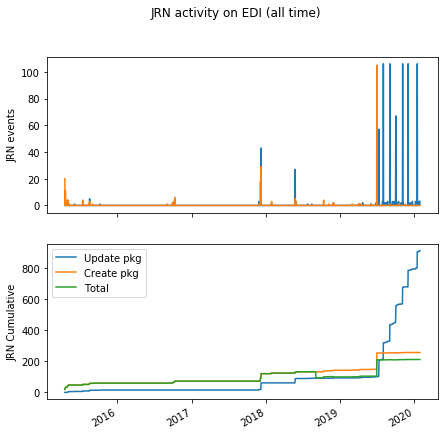

In [50]:
# All time plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(dEDI.index, dEDI.n_update, label='Update pkg')
ax[0].plot(dEDI.index, dEDI.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(dEDI.index, dEDI.n_update.cumsum(), label='Update pkg')
ax[1].plot(dEDI.index, dEDI.n_create.cumsum(), label='Create pkg')
ax[1].plot(dEDI.index, dEDI.n_tot.cumsum(), label='Total')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (all time)')
plt.legend()

import os
fig.savefig(os.path.expanduser("~/GD_gmaurer.jrn.lter/IM_diagnostics/JRN_EDI_all_{0}.png".format(now)),
            dpi=150)

### Total number of packages

In [51]:
dEDI.n_tot.sum()

211

### Total number of non-met packages

In [52]:
df.loc[df.studyid!='437',['n_update', 'n_create', 'n_tot']].resample('D').sum().n_tot.sum()


105

### Plot without met

In [53]:
# This is after the LTER probabtion shock and after some big 
# delete operations on EDI
startdt = "2015-04-01"

rdEDI_nomet = df.loc[np.logical_and(df.studyid!='437',
                                        df.index > startdt),
                         ['n_update', 'n_create', 'n_tot']].resample('D').sum()
rdEDI_nomet.head()

,n_update,n_create,n_tot
date,,,
2015-04-17,0,20,20
2015-04-18,0,1,1
2015-04-19,0,0,0
2015-04-20,0,11,11
2015-04-21,0,2,2


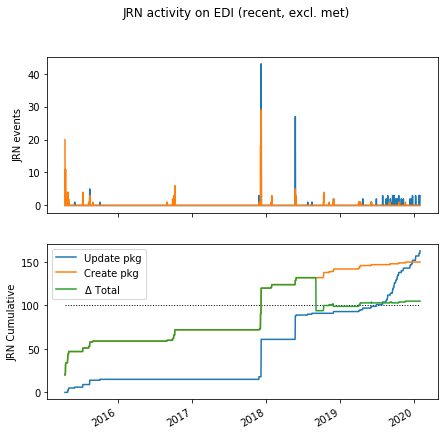

In [54]:
# Recent plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(rdEDI_nomet.index, rdEDI_nomet.n_update, label='Update pkg')
ax[0].plot(rdEDI_nomet.index, rdEDI_nomet.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(rdEDI_nomet.index, rdEDI_nomet.n_update.cumsum(), label='Update pkg')
ax[1].plot(rdEDI_nomet.index, rdEDI_nomet.n_create.cumsum(), label='Create pkg')
ax[1].plot(rdEDI_nomet.index, rdEDI_nomet.n_tot.cumsum(), label='$\Delta$ Total')
ax[1].hlines(y=100, xmin=rdEDI_nomet.index.min(), xmax=rdEDI_nomet.index.max(), ls=':', lw=1)

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (recent, excl. met)')
plt.legend()

## Plot activity since Sept 2018 (excluding Met)

In [55]:
# This is after the LTER probabtion shock and after some big 
# delete operations on EDI
startdt = "2018-09-05"

rdEDI_nomet = df.loc[np.logical_and(df.studyid!='437',
                                        df.index > startdt),
                         ['n_update', 'n_create', 'n_tot']].resample('D').sum()
rdEDI_nomet.head()

,n_update,n_create,n_tot
date,,,
2018-10-10,0,1,1
2018-10-11,0,1,1
2018-10-12,0,4,4
2018-10-13,0,0,0
2018-10-14,0,0,0


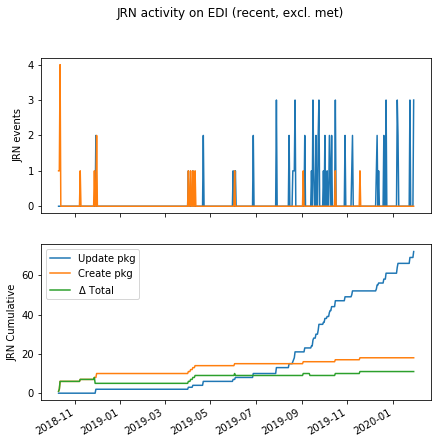

In [56]:
# Recent plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(rdEDI_nomet.index, rdEDI_nomet.n_update, label='Update pkg')
ax[0].plot(rdEDI_nomet.index, rdEDI_nomet.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(rdEDI_nomet.index, rdEDI_nomet.n_update.cumsum(), label='Update pkg')
ax[1].plot(rdEDI_nomet.index, rdEDI_nomet.n_create.cumsum(), label='Create pkg')
ax[1].plot(rdEDI_nomet.index, rdEDI_nomet.n_tot.cumsum(), label='$\Delta$ Total')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (recent, excl. met)')
plt.legend()

fig.savefig(os.path.expanduser(
    "~/GD_gmaurer.jrn.lter/IM_diagnostics/JRN_EDI_recNoMet_{0}.png".format(now)),
            dpi=150)

## Summary since Sept 2018 (after LTER7 probation)

In [57]:
# Monthly progress
rmEDI_nomet = rdEDI_nomet.resample('M').sum()
rmEDI_nomet

,n_update,n_create,n_tot
date,,,
2018-10-31,0,6,6
2018-11-30,2,4,-1
2018-12-31,0,0,0
2019-01-31,0,0,0
2019-02-28,0,0,0
2019-03-31,0,0,0
2019-04-30,4,4,4
2019-05-31,0,0,0
2019-06-30,4,1,0


In [58]:
# Unique packages updated (excluding met)
rEDI = df.loc[df.index > startdt,]
uniqueUp = rEDI.loc[np.logical_and(rEDI.studyid!='437', rEDI.action=='updateDataPackage'),].pkgid.unique()
#rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
uniqueUp

array([210338004, 210338002, 210351003, 210328003, 210328001, 210120001,
       210127001, 210380001, 210288001, 210351001, 210351002, 210461001,
       210086003, 210086008, 210002001, 210086009, 210086005, 210086004,
       210086007, 210308004, 210228001, 210120002, 210013001, 210086002,
       210086001, 210121005, 210121008, 210407001, 210086006, 210119001,
       210011005, 210001002, 210011002, 210011003, 210011004, 210013002,
       210013003, 210412001, 210012001, 210012002, 210010001, 210122001,
       210328002, 210308001, 210308002, 210308003, 210308005, 210126003,
       210262001, 210262004, 210262005, 210128001, 210128002])

In [59]:
# Unique updates since last meeting
last_meeting = '2019-10-18'

vrEDI = df.loc[df.index >= last_meeting]
uR = vrEDI.loc[np.logical_and(vrEDI.studyid!='437', vrEDI.action=='updateDataPackage'),].pkgid.unique()
# Unique updates before last meeting (to startdt)
oEDI = df.loc[np.logical_and(df.index > startdt, df.index < last_meeting),]
uO = oEDI.loc[np.logical_and(oEDI.studyid!='437', oEDI.action=='updateDataPackage'),].pkgid.unique()
print(uR)
print(uO)

[210013002 210013003 210412001 210012001 210012002 210010001 210086002
 210086001 210122001 210380001 210328001 210328002 210328003 210308001
 210308002 210308003 210308005 210126003 210262001 210262004 210262005
 210128001 210128002]
[210338004 210338002 210351003 210328003 210328001 210120001 210127001
 210380001 210288001 210351001 210351002 210461001 210086003 210086008
 210002001 210086009 210086005 210086004 210086007 210308004 210228001
 210120002 210013001 210086002 210086001 210121005 210121008 210407001
 210086006 210119001 210011005 210001002 210011002 210011003 210011004]


In [60]:
uR[~np.in1d(uR, uO)]

array([210013002, 210013003, 210412001, 210012001, 210012002, 210010001,
       210122001, 210328002, 210308001, 210308002, 210308003, 210308005,
       210126003, 210262001, 210262004, 210262005, 210128001, 210128002])

In [61]:
# Unique packages deleted
uniqueDel = rEDI.loc[np.logical_and(rEDI.studyid!='437', rEDI.action=='deleteDataPackage'),].pkgid.unique()
uniqueDel

array([210038001, 210338007, 210338008, 210169001, 210169002,  21038001,
       210860002])

In [62]:
# Unique packages created (See above)
uniqueCreate = rEDI.loc[np.logical_and(rEDI.studyid!='437', rEDI.action=='createDataPackage'),].pkgid.unique()
uniqueCreate

array([210520001, 210327001, 210338005, 210338006, 210338007, 210338008,
       210472001, 210380001, 210128001, 210128002, 210351003, 210328003,
       210328001, 210328002,  21038001, 210860002, 210011001,       100])